In [4]:
pip -q install torch torchvision scikit-learn  #Install required libs

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\Reeve\AppData\Local\Programs\Python\Python314\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#Install': Expected package name at the start of dependency specifier
    #Install
    ^


In [1]:
#Imports + config
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, f1_score

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

DATASET_DIR = Path("../data/raw/knee-osteoarthritis-dataset-with-severity")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [11]:
# Transforms + Datasets + Loaders
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2  

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(DATASET_DIR / "train", transform=train_tfms)
val_ds   = datasets.ImageFolder(DATASET_DIR / "val",   transform=val_tfms)

print("Classes:", train_ds.classes)
print("Train size:", len(train_ds), "Val size:", len(val_ds))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Classes: ['0', '1', '2', '3', '4']
Train size: 5778 Val size: 826


In [8]:
# Class weights (handles imbalance)
from collections import Counter

train_labels = [y for _, y in train_ds.samples]
counts = Counter(train_labels)
num_classes = len(train_ds.classes)

class_counts = np.array([counts[i] for i in range(num_classes)], dtype=np.float32)
weights = class_counts.sum() / (num_classes * class_counts)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class counts:", class_counts.astype(int))
print("Class weights:", weights.round(3))


Class counts: [2286 1046 1516  757  173]
Class weights: [0.506 1.105 0.762 1.527 6.68 ]


In [9]:
# Build ResNet-18 baseline
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(train_ds.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
# Train for 5 epochs (baseline run)
def run_epoch(model, loader, train=True):
    model.train(train)
    all_preds, all_true = [], []
    total_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.detach().cpu().numpy())
        all_true.extend(y.detach().cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds, average="macro")
    return avg_loss, acc, f1

EPOCHS = 5

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, train=True)
    va_loss, va_acc, va_f1 = run_epoch(model, val_loader, train=False)

    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} || "
          f"val loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")


Epoch 01 | train loss 1.1665 acc 0.443 f1 0.414 || val loss 1.0962 acc 0.527 f1 0.499
Epoch 02 | train loss 0.8727 acc 0.566 f1 0.592 || val loss 1.0050 acc 0.546 f1 0.585
Epoch 03 | train loss 0.7772 acc 0.597 f1 0.637 || val loss 0.9676 acc 0.590 f1 0.626
Epoch 04 | train loss 0.7442 acc 0.616 f1 0.650 || val loss 1.1142 acc 0.510 f1 0.580
Epoch 05 | train loss 0.7165 acc 0.634 f1 0.668 || val loss 1.0312 acc 0.567 f1 0.601


In [12]:
test_ds = datasets.ImageFolder(DATASET_DIR / "test", transform=val_tfms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

test_loss, test_acc, test_f1 = run_epoch(model, test_loader, train=False)

print(f"TEST SET | loss {test_loss:.4f} acc {test_acc:.3f} f1 {test_f1:.3f}")

TEST SET | loss 0.9260 acc 0.598 f1 0.629


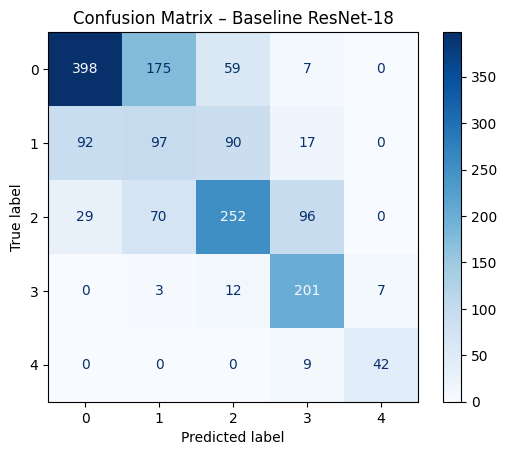

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=test_ds.classes)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Baseline ResNet-18")
plt.show()


In [14]:
torch.save(model.state_dict(), "resnet18_baseline.pth")